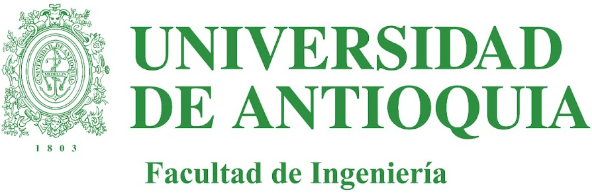

# **Análisis de Bio-señales para Computación Afectiva**
## Docente: Hernán Felipe García Arias
## Por: David Alexander Sánchez, Juan Pablo Areiza
### Universidad de Antioquia, Medellín 2023

## **Librerías**

In [1]:
!pip install peakutils #La biblioteca PeakUtils en Python proporciona utilidades relacionadas con la detección de picos en datos unidimensionales

In [2]:
import scipy.io as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import pandas as pd
import peakutils
from sklearn.preprocessing import MinMaxScaler
from scipy.fft import fft, fftfreq

## **Dataset**

### Descripción

[DEAPdataset](https://www.eecs.qmul.ac.uk/mmv/datasets/deap/index.html) es una base de datos que contiene un conjunto de datos para el análisis de emociones utilizando señales de EEG, fisiológicas y de video. El dataset fue recopilado por el grupo de investigación Multimodal Interaction Lab en la Universidad Queen Mary de Londres. Contiene datos de 32 sujetos, cada uno expuesto a 40 clips de video cortos mientras se registraban sus señales fisiológicas y EEG. Los sujetos también proporcionaron calificaciones subjetivas de su experiencia emocional durante cada clip.

In [3]:
fs = 128 #En la descripción de los datos se informa que la frecuencia de muestreo es de 128 Hz

### Carga de datos

In [4]:
# s14: https://drive.google.com/file/d/1cNMil1P60z-XrqExnnKvmggmXWhI3glZ/view?usp=sharing
!gdown '1cNMil1P60z-XrqExnnKvmggmXWhI3glZ'
# s15: https://drive.google.com/file/d/1Fu3HL-cB64lTfuZS8iPhIfaJIsl1OszD/view?usp=sharing
!gdown '1Fu3HL-cB64lTfuZS8iPhIfaJIsl1OszD'
# s16: https://drive.google.com/file/d/1cBN0CYdrsUsVO77PyNq-Jkyh5pc0FI22/view?usp=sharing
!gdown '1cBN0CYdrsUsVO77PyNq-Jkyh5pc0FI22'
# s17: https://drive.google.com/file/d/1bMObQcIFrNalRmD1LaNuqVSTeqaeGqR3/view?usp=sharing
!gdown '1bMObQcIFrNalRmD1LaNuqVSTeqaeGqR3'

Downloading...
From: https://drive.google.com/uc?id=1cNMil1P60z-XrqExnnKvmggmXWhI3glZ
To: /content/s14.mat
100% 80.6M/80.6M [00:00<00:00, 198MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Fu3HL-cB64lTfuZS8iPhIfaJIsl1OszD
To: /content/s15.mat
100% 80.7M/80.7M [00:00<00:00, 174MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cBN0CYdrsUsVO77PyNq-Jkyh5pc0FI22
To: /content/s16.mat
100% 80.8M/80.8M [00:00<00:00, 135MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bMObQcIFrNalRmD1LaNuqVSTeqaeGqR3
To: /content/s17.mat
100% 80.7M/80.7M [00:00<00:00, 166MB/s]


In [5]:
#Carga de archivos .mat
datosP1 = sc.loadmat('s14.mat')
datosP2 = sc.loadmat('s15.mat')
datosP3 = sc.loadmat('s16.mat')
datosP4 = sc.loadmat('s17.mat')

In [6]:
signalsP1 = datosP1['data']
labelsP1 = datosP1['labels']

signalsP2 = datosP2['data']
labelsP2 = datosP2['labels']

signalsP3 = datosP3['data']
labelsP3 = datosP3['labels']

signalsP4 = datosP4['data']
labelsP4 = datosP4['labels']

In [7]:
signalsP1.shape

(40, 40, 6528)


Las variables signalPX, almacenan todas las reacciones emocionales derivadas de las señales biológicas para los 40 videos distintos.

## **Filtros**

In [8]:
def filter(signal_input, f_order, f_cutoff, fs, filter_type):
    nyquist_freq = 0.5 * fs
    a = signal.butter(f_order, f_cutoff, btype=filter_type, analog=False, fs=fs, output='sos')
    filtered_signal = signal.sosfilt(a, signal_input)
    return filtered_signal


## **Descripción de señales**

1. **GSR (Galvanic Skin Response)**: También conocida como **Electrodermal Activity (EDA)** o **Skin Conductance (SC)**, la respuesta galvánica de la piel es una medida de la conductividad eléctrica de la piel. Se origina a partir de la activación autónoma de las glándulas sudoríparas en la piel. La GSR es sensible a la actividad simpática autónoma y se utiliza para evaluar el comportamiento emocional y el nivel de excitación [[1]](https://imotions.com/blog/learning/research-fundamentals/galvanic-skin-response/).

2. **Blood volume pressure**: Es una medida de la fuerza ejercida por la sangre contra las paredes de las arterias. La presión arterial se mide en milímetros de mercurio (mmHg) y se expresa en dos valores: presión sistólica (la presión cuando el corazón late) y presión diastólica (la presión cuando el corazón está en reposo entre latidos) [[2]](https://minds.wisconsin.edu/bitstream/handle/1793/80044/How%20do%20Physical%20responses%20such%20as%20respiratory%20frequency_heart%20rate_%20and%20galvanic%20skin%20response_GSR_change%20under%20emotional.pdf?sequence=1).

3. **Respiration pattern**: El patrón respiratorio se refiere a cómo una persona respira, incluyendo la frecuencia respiratoria, el ritmo y la profundidad de la respiración. Los patrones respiratorios normales varían según la edad, el estado físico y otros factores [[2]](https://minds.wisconsin.edu/bitstream/handle/1793/80044/How%20do%20Physical%20responses%20such%20as%20respiratory%20frequency_heart%20rate_%20and%20galvanic%20skin%20response_GSR_change%20under%20emotional.pdf?sequence=1).

4. **Skin temperature**: La temperatura de la piel se refiere a la temperatura de la cutánea. La temperatura cutánea puede variar según factores como el clima, la actividad física y las condiciones médicas. La temperatura cutánea se puede medir utilizando termómetros especiales o dispositivos portátiles [[2]](https://minds.wisconsin.edu/bitstream/handle/1793/80044/How%20do%20Physical%20responses%20such%20as%20respiratory%20frequency_heart%20rate_%20and%20galvanic%20skin%20response_GSR_change%20under%20emotional.pdf?sequence=1).

5. **EMG (Electromyography) y EOG (Electrooculography)**: El electromiograma (EMG) es una técnica que registra la actividad eléctrica de los músculos. La electrooculografía (EOG) registra los movimientos oculares mediante electrodos colocados alrededor de los ojos [[3]](https://www.sensortips.com/featured/what-is-the-difference-between-an-ecg-eeg-emg-and-eog/).

6. **EEG (Electroencephalography)**: La electroencefalografía es una técnica que registra la actividad eléctrica del cerebro mediante electrodos colocados en el cuero cabelludo [[3]](https://www.sensortips.com/featured/what-is-the-difference-between-an-ecg-eeg-emg-and-eog/).

## Etiquetas emocionales

**Excitación (arousal)**: El nivel de activación fisiológica o excitación experimentado en respuesta a un estímulo, que va desde bajo (tranquilo) hasta alto (intenso).

**Valencia (valence)**: La cualidad emocional o positividad/negatividad de la experiencia subjetiva de un individuo, que va desde negativa (desagradable) hasta positiva (agradable).

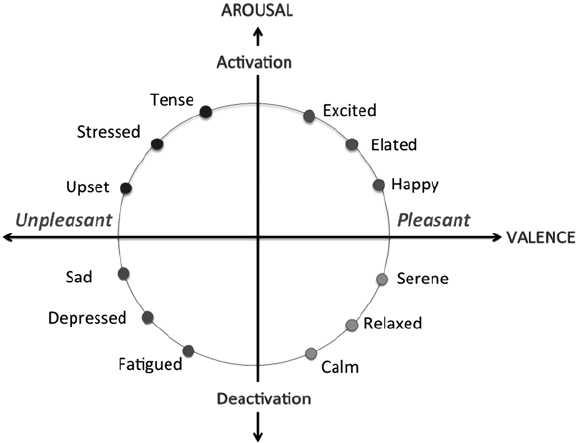


De acuerdo con el dataset, tanto Valence como Arousal son enteros entre 1 y 9, con base en esto, se realiza un grupamiento de las emociones en 3 grupos:

1. Arousal bajo o alto [1-3],[7-9] y Valence alto [7-9]: Puede etiquetarse como "Emoción Positiva".
2. Arousal bajo o alto [1-3],[7-9] y Valence bajo [1-3]: Puede etiquetarse como "Emoción Negativa".
3. Arousal y Valence que no cumpla los criterios anteriores: Puede etiquetarse como "Emoción Neutra"

In [9]:
neg = 'Negativa'
neu = 'Neutra'
pos = 'Positiva'

valence = labelsP1[:, 0]
arousal = labelsP1[:, 1]

emociones = []

for i in range(40):

    if ((arousal[i] >= 1 and arousal[i] <= 3) and (valence[i] >= 7 and valence[i] <= 9)) or ((arousal[i] >= 7 and arousal[i] <= 9) and (valence[i] >= 7 and valence[i] <= 9)):
        emociones.append(pos)
    elif ((arousal[i] >= 1 and arousal[i] <= 3) and (valence[i] >= 1 and valence[i] <= 3)) or ((arousal[i] >= 7 and arousal[i] <= 1) and (valence[i] >= 7 and valence[i] <= 3)):
        emociones.append(neg)
    else:
        emociones.append(neu)

In [10]:
# Se añaden las emociones en un dataframe
df = pd.DataFrame({'Emociones': emociones}, index=[f'Video {i+1}' for i in range(40)])

## **GSR**

Características:
- Average skin resistance
- Number of local minima in the GSR signal
- Average rising time of the GSR signal
- 10 Spectral power in the [0-2.4] Hz bands

In [12]:
def gsr_features(gsr_signal, fs):
    # Average skin resistance
    avg_resistance = np.mean(gsr_signal)

    # Number of local minima in the GSR signal
    inverted_signal = -1 * gsr_signal
    indices_minima = peakutils.indexes(inverted_signal, thres=0.02/max(inverted_signal), min_dist=fs)
    num_minima = len(indices_minima)

    # Average rising time of the GSR signal
    indices_maxima = peakutils.indexes(gsr_signal, thres=0.02/max(gsr_signal), min_dist=fs)
    rise_times = []
    for i in range(len(indices_maxima)-1):
        rise_time = indices_maxima[i+1] - indices_maxima[i]
        rise_times.append(rise_time)
    avg_rise_time = np.mean(rise_times)

    # Spectral power in the [0-2.4] Hz bands
    filtered_signal = filter(gsr_signal,8,[0.0001,2.4],fs,"bandpass") #La frecuencia de corte 0.0001 se debe a que la frecuencia 0 Hz no está permitida
    yf = fft(filtered_signal)
    N = len(filtered_signal)
    T = 1./fs
    xf = fftfreq(N, T)[0:N//2]
    spectral_power = 2.0/N * np.abs(yf[0:N//2])
    # Ordenar las potencias espectrales en orden descendente
    sorted_indices = np.argsort(spectral_power)[::-1]

    # Obtener las 10 mayores potencias espectrales y sus correspondientes frecuencias
    top_spectral_power = spectral_power[sorted_indices[:10]]

    return avg_resistance, num_minima, avg_rise_time, top_spectral_power

In [13]:
# Se normaliza con el objeto MinMaxScaler
scaler = MinMaxScaler()

column_titles = ['GSR_Avg_Resistance', 'GSR_Num_Minima', 'GSR_Avg_Rise_Time']

# Creación de una lista para almacenar los DataFrames temporales de cada video
dfs = []

# Se itera a través de las señales GSR y extraer características
for video_index in range(40):
    gsr_signal = signalsP1[video_index, 36, :]
    normalized_gsr_signal = scaler.fit_transform(gsr_signal.reshape(-1, 1))
    avg_resistance, num_minima, avg_rise_time, spectral_power = gsr_features(gsr_signal, fs)  # Extraer características

    # Crear un DataFrame temporal para el video actual
    df_video = pd.DataFrame([[avg_resistance, num_minima, avg_rise_time] + list(spectral_power[:10])],
                            columns=column_titles + [f'GSR_Spectral_Power_{i+1}' for i in range(10)],
                            index=[f'Video {video_index+1}'])

    # Agregar el DataFrame temporal a la lista
    dfs.append(df_video)


# Concatenar todos los DataFrames temporales en uno solo
df_aux = pd.concat(dfs)

In [15]:
df = df.join(df_aux) #Se une el dataframe que contiene los datos de las características de GSR con las emociones

In [16]:
df

,Emociones,GSR_Avg_Resistance,GSR_Num_Minima,GSR_Avg_Rise_Time,GSR_Spectral_Power_1,GSR_Spectral_Power_2,GSR_Spectral_Power_3,GSR_Spectral_Power_4,GSR_Spectral_Power_5,GSR_Spectral_Power_6,GSR_Spectral_Power_7,GSR_Spectral_Power_8,GSR_Spectral_Power_9,GSR_Spectral_Power_10
Video 1,Positiva,-18005.683435,13,410.461538,33405.444773,12415.736592,10698.074852,5155.897038,3874.836546,3503.587486,3068.908742,3010.240760,2483.330703,2382.528759
Video 2,Neutra,-8794.650746,15,350.117647,16293.422095,9325.021496,5975.311454,2949.566499,1935.672059,1845.186864,1426.637894,974.837702,938.945941,900.433328
Video 3,Neutra,-1331.408630,18,336.222222,3182.753201,2389.673359,980.841268,448.734194,360.344443,279.304636,230.297298,229.224006,217.936368,208.449839
Video 4,Neutra,3491.283824,15,346.750000,6450.935589,4203.907937,1904.715558,1479.992938,1134.924769,914.080432,909.330659,664.378771,367.873687,247.731055
Video 5,Neutra,-3736.386024,23,258.833333,6978.202980,3847.452251,1573.085329,1374.493839,1294.347548,1225.965253,1053.985543,868.306058,835.965634,687.860006
Video 6,Neutra,-848.909184,17,375.764706,4486.181129,1985.445479,1752.872762,1198.571632,1061.370592,899.509698,695.488903,530.219099,324.993263,315.578619
Video 7,Neutra,-8999.583679,14,408.666667,16682.119116,5281.211668,4710.258120,2226.435443,1789.782908,1376.116691,1004.080472,892.633971,828.212384,755.781933
Video 8,Neutra,-517.923350,16,357.176471,3683.795511,1984.365301,1830.854124,805.107916,762.679028,699.233138,688.380399,643.838580,472.947422,393.654591
Video 9,Positiva,-9165.069658,11,440.307692,17116.423378,5468.787463,4656.387315,3418.487208,1769.369127,1587.434273,1583.127835,1102.209064,796.305043,740.653399
Video 10,Neutra,5519.865947,21,301.333333,10275.785337,2594.777684,2245.267133,1475.749870,1056.001069,699.515450,646.191030,445.340544,429.887209,383.280693


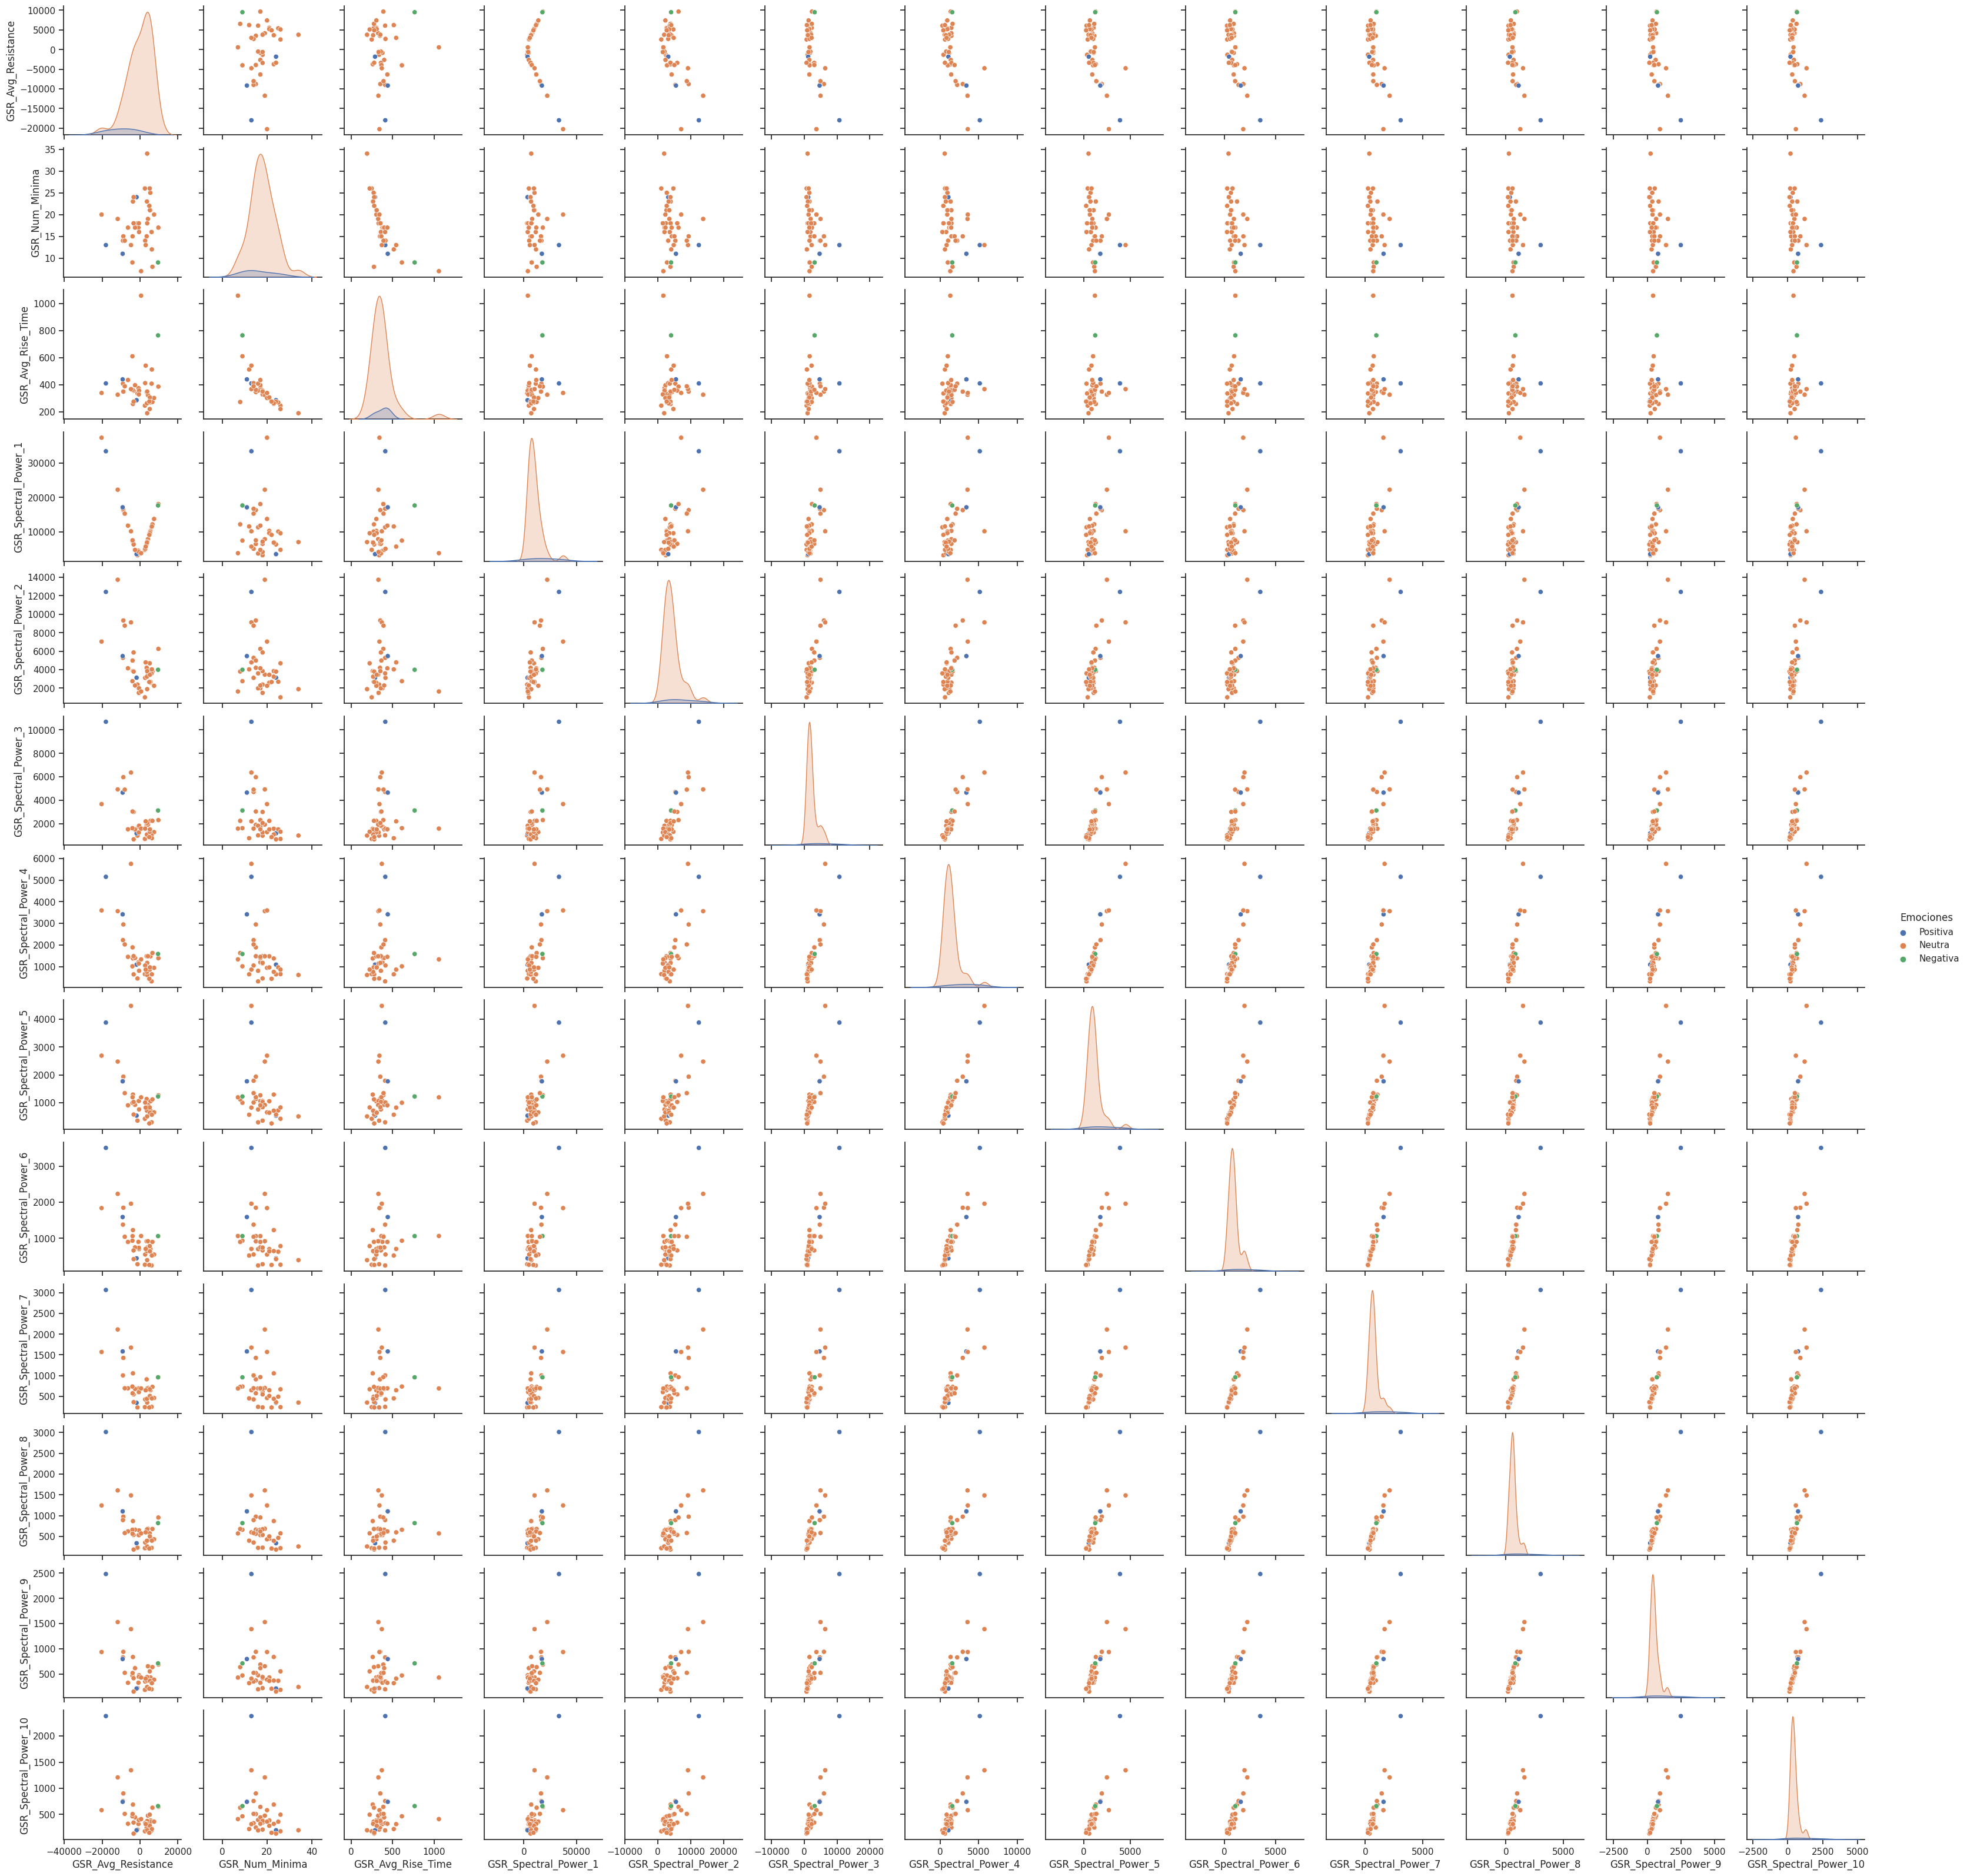

In [17]:
# Se realizan los pair plots con Seaborne
sns.set(style="ticks")
sns.pairplot(df,hue="Emociones")

# Mostrar el gráfico
plt.show()

## Referencias

1. Galvanic Skin Response (GSR): The Complete Pocket Guide. https://imotions.com/blog/learning/research-fundamentals/galvanic-skin-response/.
2. How do physiological responses such as respiratory frequency, heart .... https://minds.wisconsin.edu/bitstream/handle/1793/80044/How%20do%20Physical%20responses%20such%20as%20respiratory%20frequency_heart%20rate_%20and%20galvanic%20skin%20response_GSR_change%20under%20emotional.pdf?sequence=1.
3. What is the difference between an ECG, EEG, EMG and EOG? - Sensor Tips. https://www.sensortips.com/featured/what-is-the-difference-between-an-ecg-eeg-emg-and-eog/.
4. PeakUtils · PyPI. https://pypi.org/project/PeakUtils/.